# Importing Libraries

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import color
from scipy.stats import multivariate_normal
from Lab2 import MR8_set,add_img_to_features

# 1) Principal Component Analysis

## 1.1)
 Read in your training image as an RGB image. Convert your training image to HSV and apply
the MR8 filter bank to both the RGB and HSV image. This should give you 54 features (3
from the RGB and HSV channels respectively, as well as the output of the 8 MR8 filters applied
to each image channel). Before we will create our classifier we are first going to reduce the
dimensionality of our features.

In [31]:
train_image = plt.imread("./images/image-110.jpg")
train_image_hsv = color.rgb2hsv(train_image)
validation_image = plt.imread("./images/image-83.jpg")
validation_image_hsv = color.rgb2hsv(validation_image)
test_image = plt.imread("./images/image-35.jpg")
test_image_hsv = color.rgb2hsv(test_image)

features = []
mr8_rgb = MR8_set(train_image,size=49)
mr8_hsv = MR8_set(train_image_hsv,size=49)

features =  add_img_to_features(train_image,features)
features =  add_img_to_features(train_image_hsv,features)

for i in range(3):
    for j in range(3):
        if i == 2 and j == 2:
            continue
        features =  add_img_to_features(mr8_rgb[i][j],features)
        features =  add_img_to_features(mr8_hsv[i][j],features)

features = np.array(features)
print(f'The shape of the feature vector is: {np.shape(features)}')


The shape of the feature vector is: (54, 270000)


## 1.2) 
For your training image, calculate the covariance of the features using all of the pixels (remember
to flatten the length and width of the image).

In [32]:
cov_train = np.cov(features)

## 1.3)
Calculate the eigenvectors of the covariance matrix from Question 2. Hint: np.linalg.eigh(·)
(this function returns your eigenvectors is ascending order with the columns being the eigen-
vectors. So you first principal component will be at eig_vecs[:,-1]. You may want to have
your eigenvectors in descending order. For this use np.flip(eig_vecs, axis=1)).

In [33]:
eig_vectors = np.linalg.eigh(cov_train)[1]
eig_vectors = np.fliplr(eig_vectors)

## 1.4) 
Make sure that you now have the eigenvectors in a matrix with each column as an eigenvector
(principal component) with the eigenvectors in descending order (the eigenvector corresponding
to the largest eigenvalue must be in the first column). Use X̂ = X · E0:n where X is your P × 54
matrix containing the P pixels with 54 features, E0:n is your (54 × n) matrix of eigenvectors
using only the first n columns, X̂ is pixels after the dimensionality reduction and · denotes
matrix multiplication. n determines the number of principal components we use and can be set
to n = 3 to start. Note that for X̂ = X · E0:n we are multiplying a (P × 54) matrix with a (54 × n)
matrix and so we have X̂ as a (P × n) matrix where n is also the new number of features.

In [40]:
def reduce_dimension(features,eigenvectors,n):
    x_hat = np.matmul(features,eigenvectors[:,:n])
    return x_hat

In [51]:
## Using 
reduced_features = reduce_dimension(features.T,eig_vectors,3)

print(f'The shape of the reduced feature vector is: {np.shape(reduced_features)}')

The shape of the reduced feature vector is: (270000, 3)


# 2) Including a Foreground Distribution

# 2.1) 
Using the mask for your training data, separate your pixels from the output of Question 1 (the
output image from the dimensionality reduction) into the foreground and background pixels.

In [63]:
train_mask = plt.imread("./images/mask-110.png")
train_mask =  cv.cvtColor(train_mask,cv.COLOR_RGBA2GRAY)

background_indices = np.where(train_mask.flatten() == 0)
puzzle_indices = np.where(train_mask.flatten() != 0)

background_pixels = reduced_features[background_indices[0]]
foreground_pixels  = reduced_features[puzzle_indices[0]]

# 2.2) 
Compute the mean (µ) and covariance matrix (Σ) for both the foreground (µf , Σf ) and back-
ground (µb , Σb ) pixels. Remember that the mean and covariance matrix are the parameters of
a normal distribution, P (X|µb , Σb ), which tells us the likelihood of seeing a specific set of fea-
tures, X, for a pixel given that it is a background pixel. We can consider another similar model
P (X|µf , Σf ), which tells us the likelihood of seeing a specific set of features, X, for a pixel given
that is in the foreground. For now, we will use multivariate normal distributions for both models.

In [66]:
mean_background = np.mean(background_pixels.T,axis=1)
covariance_background = np.cov(background_pixels.T)

mean_foreground = np.mean(foreground_pixels.T,axis=1)
covariance_foreground = np.cov(foreground_pixels.T)

In [71]:
background_distribution = multivariate_normal(mean= mean_background, cov= covariance_background)

foreground_distribution = multivariate_normal(mean = mean_foreground, cov = covariance_foreground)

# 2.3) 
For your validation image, calculate the 54 original features and project this onto the n principal
components from Section 1 using V̂ = V · E0:n where V is the validation image’s pixels and V̂
is the dimensionality reduced validation image. Note that we still use the principal components
from our training data for the projection.

In [72]:
validation_features = []
mr8_rgb = MR8_set(validation_image,size=49)
mr8_hsv = MR8_set(validation_image_hsv,size=49)

validation_features =  add_img_to_features(validation_image,validation_features)
validation_features =  add_img_to_features(validation_image_hsv,validation_features)

for i in range(3):
    for j in range(3):
        if i == 2 and j == 2:
            continue
        validation_features =  add_img_to_features(mr8_rgb[i][j],validation_features)
        validation_features =  add_img_to_features(mr8_hsv[i][j],validation_features)

validation_features = np.array(validation_features)
print(f'The shape of the feature vector is: {np.shape(validation_features)}')

The shape of the feature vector is: (54, 270000)


In [74]:
validation_reduced_features = reduce_dimension(validation_features.T,eigenvectors=eig_vectors,n=3)

# 2.4) 
Now infer the probability density (i.e. evaluate the probability density function) for each pixel’s
reduced dimensional representations. This indicates the probability of seeing these features
given that it is a background or foreground pixel. For the foreground and background models,
separately use the means and variances found in Question 2.

In [76]:
## Getting PDF using background distribution
valid_bg_pdf = background_distribution.pdf(validation_reduced_features)

## Getting PDF using foreground distribution
valid_fg_pdf = foreground_distribution.pdf(validation_reduced_features)

# 2.5)
For each pixel in the validation image compute the value of
$C= \frac {P (X|µb , Σb )}{ P (X|µf , Σf ) + P (X|µb , Σb )}$
Note that (P (X|µf , Σf ) + P (X|µb , Σb )) normalizes the likelihood P (X|µb , Σb ) so that it gives the
probability of X being a background pixel, given the training data that we have seen. If C ≥ 0.5
classify it as a background pixel, else classify it as a foreground pixel. Does your model achieve
better accuracy than when you just used a distribution for the background pixels with the 54
features?

In [85]:
C = valid_bg_pdf/(valid_bg_pdf+valid_fg_pdf)

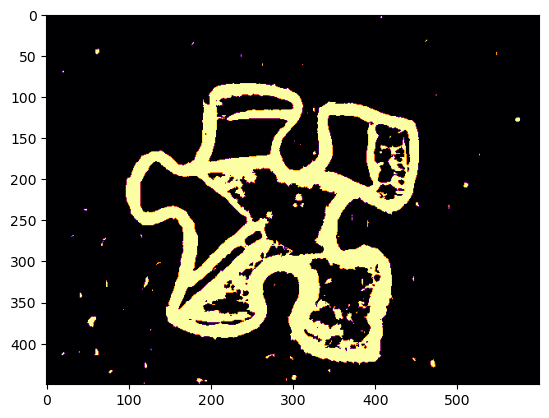

In [93]:
cast_to_bg = np.where(C>=0.5)
cast_to_fg = np.where(C < 0.5)
C[cast_to_bg] = 0
C[cast_to_fg] = 1
C = np.reshape(C,np.shape(train_mask))
plt.imshow(C,cmap="inferno")
plt.show()